# Inverter Availability

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')

import rdtools
print(rdtools.__version__)
print(rdtools.__file__)
import pandas as pd
import numpy as np
import pvlib

from rdtools import losses

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)


1.2.0+177.g8105a00.dirty
..\rdtools\__init__.py


## Get some test data

In [3]:
# make up some test clear-sky meter power data
st = '2019-01-03 00:00'
ed = '2019-01-10 00:00'
kWdc = 100.0
gamma = -0.004
lat, lon = 40, -80
tilt = 20
azi = 180
idx = pd.date_range(st, ed, freq='15T', closed='left', tz='US/Eastern')
location = pvlib.location.Location(lat, lon)
solpos = location.get_solarposition(idx)
clearsky = location.get_clearsky(idx, solar_position=solpos)
poa = pvlib.irradiance.get_total_irradiance(tilt,
                                            azi,
                                            solpos['zenith'],
                                            solpos['azimuth'],
                                            clearsky['dni'],
                                            clearsky['ghi'],
                                            clearsky['dhi'])
poa = poa['poa_global']
is_daylight = solpos['elevation'] > 0
tamb = pd.Series(index=idx, data=25)
tcell = pvlib.pvsystem.sapm_celltemp(poa, 0, tamb)
tcell = tcell['temp_cell']

power = poa/1000 * (1 + gamma*(tcell - 25))
inverter_power = pd.DataFrame({
    'inv0': (100.0 * power).clip(upper=50), 
    'inv1': (150.0 * power).clip(upper=75),
    'inv2': (50.0 * power).clip(upper=25)
})

expected_power = inverter_power.sum(axis=1)
production_profile = losses.signal_to_profile(expected_power)

# real downtime
inverter_power.loc['2019-01-03', 'inv0'] = 0
inverter_power.loc['2019-01-05 10:00' : '2019-01-05 14:00', 'inv1'] = 0
inverter_power.loc['2019-01-07 12:00' : '2019-01-08 10:00', :] = 0
inverter_power.loc['2019-01-09', 'inv0'] = 0

# record meter now, before comms outages
meter = inverter_power.sum(axis=1)

# all inverters online but not communicating
inverter_power.loc['2019-01-06'] = 0

# mixed downtime and comms
inverter_power.loc['2019-01-09', 'inv1'] = 0


## Detect inverter outages

In [4]:
online_mask = losses.is_online(inverter_power, meter)

Text(0, 0.5, 'Inverter Status')

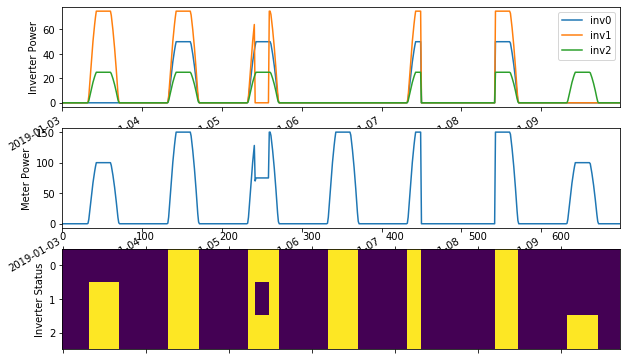

In [5]:
fig, ax = plt.subplots(3, 1)
inverter_power.plot(ax=ax[0])
ax[0].set_ylabel('Inverter Power')

meter.plot(ax=ax[1])
ax[1].set_ylabel('Meter Power')

plt.sca(ax[2])
plt.matshow(online_mask.T, aspect='auto', fignum=0)
ax[2].set_ylabel('Inverter Status')

In [6]:
lost_power = losses.downtime_loss(inverter_power, meter, online_mask, expected_power, production_profile, is_daylight)

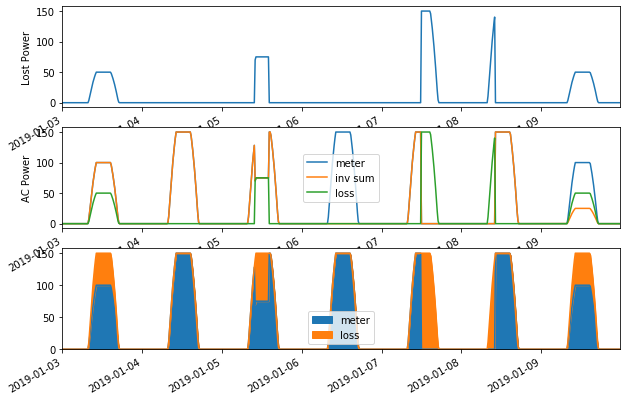

In [7]:
fig, ax = plt.subplots(3, 1)
lost_power.plot(ax=ax[0])
ax[0].set_ylabel('Lost Power')

df = pd.DataFrame({
    'meter': meter,
    'inv sum': inverter_power.sum(axis=1),
    'loss': lost_power
})
df.plot(ax=ax[1])
ax[1].set_ylabel('AC Power')

df[['meter', 'loss']].plot.area(ax=ax[2])


## Availability calculation

In [8]:
# in this simple case, assume (meter + ava_loss = P50)
expected_energy = (meter + lost_power).sum()
ava = 1 - lost_power.sum() / expected_energy.sum()
df_metrics = pd.DataFrame({
    'P50':[expected_energy],
    'Actual':[meter.sum()],
    'Availability':[ava],
})
print(df_metrics)

            P50        Actual  Availability
0  29512.811386  22259.465096      0.754231
